<a href="https://colab.research.google.com/github/agpo-ilr-uni-bonn/PromotionskollegModule6800_2024/blob/master/Example_LassoDoubleSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Example Lasso for double selection
-----------------

This is an example of how to use LASSO for model selection when we are
interested in a causal interpretation of the variables. In particularly
we are interested in explaining the effects of protected areas (*wdpa_2017*) on deforestation. Note, this example should be understood only as in illustration of the approach, for actually deriving an causal effect other aspects might need to be considered as well.

### For further details on the approach see:

**Double Selection: **
Belloni, Alexandre, Victor Chernozhukov, and Christian Hansen. 2014. “High-Dimensional Methods and Inference on Structural and Treatment Effects.” The Journal of Economic Perspectives 28 (2): 29–50.

*In case you are interested in an R implementation of the Double selection approach check out the notebook prepared from a similar lecture:
https://github.com/hstorm/LASSO_model_selection_lecture*

*Question contact: Hugo Storm (hugo.storm@ilr.uni-bonn.de)*

In [3]:
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
# import seaborn for visualization
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
from sklearn.linear_model import LinearRegression, Lasso
from sklearn import linear_model

from sklearn.linear_model import lasso_path, enet_path
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV

In [4]:
# run this cell only once if you don't have wget installed
# its assumed you are using windows and have python installed
# only needed if you are running the notebook locally
# %pip install wget
#if not os.path.isfile('brazil_all_data_v2.gz'):
#    !python -m wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz
# Download data only once and make sure it is in the same folder as the notebook

# check if brazil_all_data_v2.gz is available in the current folder and if not, download it

if not os.path.isfile('brazil_all_data_v2.gz'):
    !wget  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz


--2024-08-16 19:55:38--  https://ilr-ml.s3.eu-central-1.amazonaws.com/brazil_all_data_v2.gz
Resolving ilr-ml.s3.eu-central-1.amazonaws.com (ilr-ml.s3.eu-central-1.amazonaws.com)... 3.5.139.121, 52.219.169.58, 3.5.139.190, ...
Connecting to ilr-ml.s3.eu-central-1.amazonaws.com (ilr-ml.s3.eu-central-1.amazonaws.com)|3.5.139.121|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 283350352 (270M) [application/x-gzip]
Saving to: ‘brazil_all_data_v2.gz’

brazil_all_data_v2. 100%[===================>] 270.22M  15.5MB/s    in 32s     

2024-08-16 19:56:11 (8.53 MB/s) - ‘brazil_all_data_v2.gz’ saved [283350352/283350352]



In [5]:
# load data into dataframe
df = pd.read_parquet('brazil_all_data_v2.gz')

In [6]:
# Define target (dependent) variable (% forest cover for 2018)
strY = 'perc_treecover'

# Get name of treatment variabel
strTreat =  'wdpa_2017'

# Define a list of exognous features names
lstExog = [
  'population_2015',
  'chirps_2017',
  'maize',
  'soy',
  'sugarcane',
  'perm_water',
  'travel_min',
  'cropland',
  'mean_elev',
  'sd_elev',
  'near_road',
  'chirps_2017_lag_1st_order',
  'population_2015_lag_1st_order',
  'maize_lag_1st_order',
  'soy_lag_1st_order',
  'sugarcane_lag_1st_order',
  'perc_treecover_lag_1st_order',
  'perm_water_lag_1st_order',
  'travel_min_lag_1st_order',
  'cropland_lag_1st_order',
  'mean_elev_lag_1st_order',
  'sd_elev_lag_1st_order',
  'near_road_lag_1st_order',
 ]

In [7]:
# Select the target variable
Y_all = df[strY]

# Get all exogenous features
X_exog_all =  df[lstExog]

# Get treatment variable D
D_all = df[strTreat]


In [8]:
# Split the data into train and test using only the the observations
# without protected areas
X_train_raw, X_test_raw, Y_train, Y_test, D_train, D_test = train_test_split(X_exog_all, Y_all, D_all, test_size = 0.2)

In [9]:
# Scale data to 0-1 range using sklearn MinMaxScalar object
# (see: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
scaler = MinMaxScaler()
# Use only the train data to fit the MinMaxScalar
scaler.fit(X_train_raw)

# Apply the MinMax transformation to the train and test data
X_train = scaler.transform(X_train_raw)
X_test = scaler.transform(X_test_raw)

In [10]:
# Use an sklearn function to generate polynomials of order 2
# (square terms and interaction terms)
# (see https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures.get_feature_names)
poly = PolynomialFeatures(2, interaction_only=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
print('Total number of avaliable features',X_train_poly.shape[1])
lstFeatures = poly.get_feature_names_out()
# Show feature names
# list(lstFeatures)

# Transform to pandas df for better readability
X_train_poly =  pd.DataFrame(X_train_poly, columns=lstFeatures, index=X_train_raw.index)
X_test_poly =  pd.DataFrame(X_test_poly, columns=lstFeatures, index=X_test_raw.index)


Total number of avaliable features 277


In [11]:
# Transform to pandas df for better readability
X_train =  pd.DataFrame(X_train, columns=lstExog, index=X_train_raw.index)


In [12]:
# Use this cell to use the polynomial features, if not executing this
# only  the original variables (no square term,
# no interaction terms) are considered below

#X_train = X_train_poly.iloc[:,1:] # "1:" to exclude constant
#lstExog = lstFeatures[1:] # "1:" to exclude constant


### Perpare function for finding alpha

In [13]:
lstAlpha = np.logspace(-6, -4, num = 10, base = 2)
lstAlpha

array([0.015625  , 0.01822702, 0.02126234, 0.02480314, 0.02893358,
       0.03375187, 0.03937253, 0.0459292 , 0.05357775, 0.0625    ])

In [14]:
def LassoGetBestAlpha(X,Y,lstAlpha, plot=True):

  modLasso = LassoCV(fit_intercept=True, alphas = lstAlpha)
  modLasso.fit(X, Y)

  # Create df to hold mse_path along with alphas and std of MSE
  dfMse = pd.DataFrame([modLasso.alphas_,
                      np.mean(modLasso.mse_path_,axis=1),
                       np.std(modLasso.mse_path_,axis=1)],
                     index=['alphas','mean_mse','std_mse']).transpose()

  # Find model with lowest MSE
  minMse = dfMse.loc[dfMse['mean_mse'].min()==dfMse['mean_mse']]

  alphaBest = minMse['alphas'].iloc[0]
  mseBest = minMse['mean_mse'].iloc[0]
  mseStdBest = minMse['std_mse'].iloc[0]

  # Find the largest alpha that is within one std of the model with the lowest MSE
  alpha1std = dfMse.loc[dfMse['mean_mse']<(mseBest+mseStdBest),'alphas'].max()

  if plot:
    plt.vlines(np.log(alphaBest), modLasso.mse_path_.min(),modLasso.mse_path_.max(),linestyles='dashed',label='alphaBest' )
    plt.vlines(np.log(alpha1std), modLasso.mse_path_.min(),modLasso.mse_path_.max(),linestyles='dotted',label='alpha1std')
    plt.errorbar(np.log(modLasso.alphas_),np.mean(modLasso.mse_path_,axis=1), yerr=np.std(modLasso.mse_path_,axis=1));

  return alphaBest, alpha1std, dfMse



### OLS on all variables

In [15]:
# Run Ols with all variables
modOlsFull = LinearRegression(fit_intercept=True)
modOlsFull.fit(pd.concat([X_train,D_train], axis=1), Y_train)

dfRes = pd.DataFrame(modOlsFull.coef_,index=lstExog+[strTreat], columns=['FullModelOls'])
dfRes

,FullModelOls
population_2015,-34.683803
chirps_2017,0.485131
maize,13.028157
soy,12.999947
sugarcane,-30.729281
perm_water,-17.887003
travel_min,121.882543
cropland,1.092353
mean_elev,-47.628213
sd_elev,65.894321


### Post-Lasso

Selected variables "best" ['perm_water', 'travel_min', 'mean_elev', 'sd_elev', 'maize_lag_1st_order', 'perc_treecover_lag_1st_order', 'travel_min_lag_1st_order', 'mean_elev_lag_1st_order', 'sd_elev_lag_1st_order', 'near_road_lag_1st_order']
Selected variables "1std" ['perm_water', 'travel_min', 'mean_elev', 'sd_elev', 'maize_lag_1st_order', 'perc_treecover_lag_1st_order', 'travel_min_lag_1st_order', 'mean_elev_lag_1st_order', 'sd_elev_lag_1st_order', 'near_road_lag_1st_order']


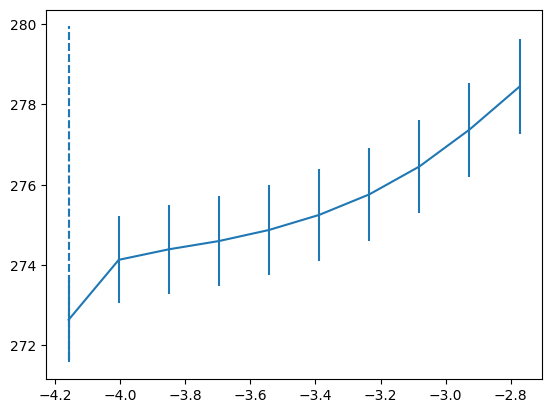

In [16]:
# Run Post-Lasso

# Find best alpha
alphaBest, alpha1std, dfMse = LassoGetBestAlpha(pd.concat([X_train,D_train], axis=1), Y_train,lstAlpha, plot=True)

# Run lasso using alphaBest
modPostLasso_best = Lasso(fit_intercept=True, alpha = alphaBest)
modPostLasso_best.fit(pd.concat([X_train,D_train], axis=1), Y_train)

# Run lasso using alpha1std
modPostLasso_best1std = Lasso(fit_intercept=True, alpha = alpha1std)
modPostLasso_best1std.fit(pd.concat([X_train,D_train], axis=1), Y_train)

# Create df to hold coef
dfPostLasso = pd.DataFrame([modPostLasso_best.coef_,
                      modPostLasso_best1std.coef_],
                     columns=lstExog+[strTreat],
                     index=['PostLasso_best',
                            'PostLasso_best1std']).replace(0,np.nan).transpose()

lstVarSelect_Post_best = list(dfPostLasso[['PostLasso_best']].dropna().index)
lstVarSelect_Post_1std = list(dfPostLasso[['PostLasso_best1std']].dropna().index)

# Remove treatment variable from list
lstVarSelect_Post_best.remove(strTreat)
lstVarSelect_Post_1std.remove(strTreat)
print('Selected variables "best"',lstVarSelect_Post_best)
print('Selected variables "1std"',lstVarSelect_Post_1std)


In [17]:
# Run "post"-OLS with best
modOlsPost_best = LinearRegression(fit_intercept=True)
modOlsPost_best.fit(pd.concat([X_train[lstVarSelect_Post_best],D_train], axis=1), Y_train)

# Run "post"-OLS with 1std
modOlsPost_1std = LinearRegression(fit_intercept=True)
modOlsPost_1std.fit(pd.concat([X_train[lstVarSelect_Post_1std],D_train], axis=1), Y_train)

# Add estimated coef to dfRes
dfRes.loc[lstVarSelect_Post_best+[strTreat],'OlsPost_best'] = modOlsPost_best.coef_
dfRes.loc[lstVarSelect_Post_1std+[strTreat],'OlsPost_1std'] = modOlsPost_1std.coef_
dfRes


,FullModelOls,OlsPost_best,OlsPost_1std
population_2015,-34.683803,NaN,NaN
chirps_2017,0.485131,NaN,NaN
maize,13.028157,NaN,NaN
soy,12.999947,NaN,NaN
sugarcane,-30.729281,NaN,NaN
perm_water,-17.887003,-8.811323,-8.811323
travel_min,121.882543,115.008886,115.008886
cropland,1.092353,NaN,NaN
mean_elev,-47.628213,-47.647103,-47.647103
sd_elev,65.894321,66.709591,66.709591


### Lasso Double selection

Lasso(alpha=0.015625)

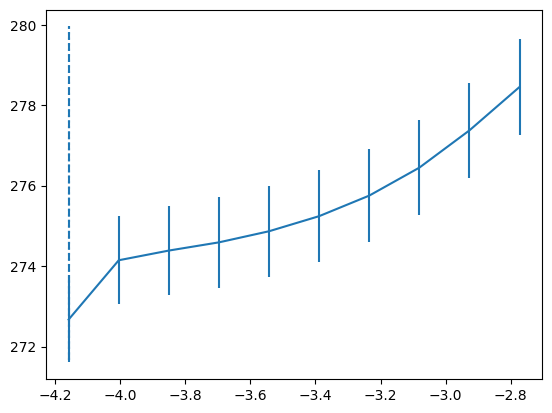

In [18]:
# Run Lasso on first stage (regression outcome on all exogenous, except treatment)

# Find best alpha
alphaBest_1st, alpha1std_1st, dfMse_1st = LassoGetBestAlpha(X_train, Y_train,lstAlpha, plot=True)

# Run lasso for first stage (1st) using alphaBest
modLasso_best_1st = Lasso(fit_intercept=True, alpha = alphaBest_1st)
modLasso_best_1st.fit(X_train, Y_train)
# Run lasso for first stage (1st) using alpha1std
modLasso_best1std_1st = Lasso(fit_intercept=True, alpha = alpha1std_1st)
modLasso_best1std_1st.fit(X_train, Y_train)


In [19]:
# Create df to hold coef
dfRes_1st = pd.DataFrame([modLasso_best_1st.coef_,
                      modLasso_best1std_1st.coef_],
                     columns=lstExog,
                     index=['Lasso_best_1st',
                            'Lasso_best1std_1st']).replace(0,np.nan).transpose()
dfRes_1st

,Lasso_best_1st,Lasso_best1std_1st
population_2015,NaN,NaN
chirps_2017,NaN,NaN
maize,NaN,NaN
soy,NaN,NaN
sugarcane,NaN,NaN
perm_water,-0.967845,-0.967845
travel_min,17.548795,17.548795
cropland,NaN,NaN
mean_elev,-5.014582,-5.014582
sd_elev,49.953262,49.953262


Lasso(alpha=0.015625)

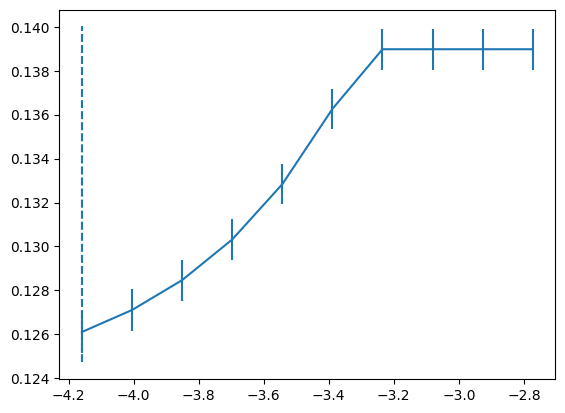

In [20]:
# Run Lasso on first stage (regression outcome on all exogenous, except treatment)

# Find best alpha
alphaBest_2st, alpha1std_2st, dfMse_2st = LassoGetBestAlpha(X_train, D_train,lstAlpha, plot=True)

# Run lasso for second stage (2st) using alphaBest
modLasso_best_2st = Lasso(fit_intercept=True, alpha = alphaBest_2st)
modLasso_best_2st.fit(X_train, D_train)
# Run lasso for second stage (2st) using alpha2std
modLasso_best1std_2st = Lasso(fit_intercept=True, alpha = alpha1std_2st)
modLasso_best1std_2st.fit(X_train, D_train)

In [21]:
# Create df to hold coef
dfRes_2st = pd.DataFrame([modLasso_best_2st.coef_,
                      modLasso_best1std_2st.coef_],
                     columns=lstExog,
                     index=['Lasso_best_2st',
                            'Lasso_best1std_2st']).replace(0,np.nan).transpose()
dfRes_2st

,Lasso_best_2st,Lasso_best1std_2st
population_2015,NaN,NaN
chirps_2017,NaN,NaN
maize,NaN,NaN
soy,NaN,NaN
sugarcane,NaN,NaN
perm_water,NaN,NaN
travel_min,NaN,NaN
cropland,NaN,NaN
mean_elev,NaN,NaN
sd_elev,NaN,NaN


In [22]:
# Run Lasso on union of set selected in first and second stage

lstVarSelect_best_1st = list(dfRes_1st[['Lasso_best_1st']].dropna().index)
lstVarSelect_best_2st = list(dfRes_2st[['Lasso_best_2st']].dropna().index)

lstVarSelect_1std_1st = list(dfRes_1st[['Lasso_best1std_1st']].dropna().index)
lstVarSelect_1std_2st = list(dfRes_2st[['Lasso_best1std_2st']].dropna().index)

# Get union of the two list (using python set() function)
lstVarSelect_best_Union = list(set(lstVarSelect_best_1st+lstVarSelect_best_2st))
lstVarSelect_1std_Union = list(set(lstVarSelect_1std_1st+lstVarSelect_1std_2st))
print('Selected variables "best"',lstVarSelect_best_Union)
print('Selected variables "1std"',lstVarSelect_1std_Union)

Selected variables "best" ['travel_min_lag_1st_order', 'perm_water', 'sd_elev', 'mean_elev_lag_1st_order', 'mean_elev', 'maize_lag_1st_order', 'near_road_lag_1st_order', 'perc_treecover_lag_1st_order', 'sd_elev_lag_1st_order', 'travel_min']
Selected variables "1std" ['travel_min_lag_1st_order', 'perm_water', 'sd_elev', 'mean_elev_lag_1st_order', 'mean_elev', 'maize_lag_1st_order', 'near_road_lag_1st_order', 'perc_treecover_lag_1st_order', 'sd_elev_lag_1st_order', 'travel_min']


In [23]:
# Run Ols with selected variables
modOlsDouble_best = LinearRegression(fit_intercept=True)
modOlsDouble_best.fit(pd.concat([X_train[lstVarSelect_best_Union],D_train], axis=1), Y_train)

modOlsDouble_1std = LinearRegression(fit_intercept=True)
modOlsDouble_1std.fit(pd.concat([X_train[lstVarSelect_1std_Union],D_train], axis=1), Y_train)

dfRes.loc[lstVarSelect_best_Union+[strTreat],'DoubleLasso_OLS_best'] = modOlsDouble_best.coef_
dfRes.loc[lstVarSelect_1std_Union+[strTreat],'DoubleLasso_OLS_1std'] = modOlsDouble_1std.coef_
dfRes


,FullModelOls,OlsPost_best,OlsPost_1std,DoubleLasso_OLS_best,DoubleLasso_OLS_1std
population_2015,-34.683803,NaN,NaN,NaN,NaN
chirps_2017,0.485131,NaN,NaN,NaN,NaN
maize,13.028157,NaN,NaN,NaN,NaN
soy,12.999947,NaN,NaN,NaN,NaN
sugarcane,-30.729281,NaN,NaN,NaN,NaN
perm_water,-17.887003,-8.811323,-8.811323,-8.811323,-8.811323
travel_min,121.882543,115.008886,115.008886,115.008886,115.008886
cropland,1.092353,NaN,NaN,NaN,NaN
mean_elev,-47.628213,-47.647103,-47.647103,-47.647103,-47.647103
sd_elev,65.894321,66.709591,66.709591,66.709591,66.709591
